In [13]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def predict(country,year1, year2):
    data = []
    years = []
    reader = csv.reader(open('API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_6224640.csv','r'), delimiter = ',', )
    for i in reader:
        if country in i:
            data = [j for j in i[4:-1]]    
        if "Country Name" in i:
            years = [j for j in i[4:-1]]

    df = pd.DataFrame({'Growth': data, 'Year': years})
    df = df.replace('', 0)
    df['Growth'] = df['Growth'].astype(float)
    df['Year'] = df['Year'].astype(int)
    subset = df[(df['Year'] >= year1) & (df['Year'] <= year2)]
    
    x = subset['Year'].values
    y = subset['Growth'].values
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    m1 = np.sum((x - x_mean)*(y - y_mean))
    m2 = np.sum((x - x_mean)**2)

    gradient = m1/m2
    intercept = y_mean-gradient*x_mean
    
    fig, ax = plt.subplots(figsize=(11,8))
    plt.plot(subset['Year'], subset['Growth'])
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title('Line Plot of Column')
    
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x, gradient*x + intercept, color='red', label='Linear Regression')
    
    predict_x = np.linspace(min(x), max(x) + 20) 
    predict_y = gradient*predict_x + intercept
    
    plt.plot(predict_x, predict_y, color='red', label='Linear Regression')
    plt.axvline(x=year2 + 10, color='green',linestyle='--')
    plt.axhline(y=gradient*(year2 + 10) + intercept, color='purple', linestyle='-.')
    
    num = gradient*(year2 + 10) + intercept
    plt.text(year2 + 10, gradient*(year2 + 10) + intercept, f"                                     {round(num ,2)}",fontsize=14)
    

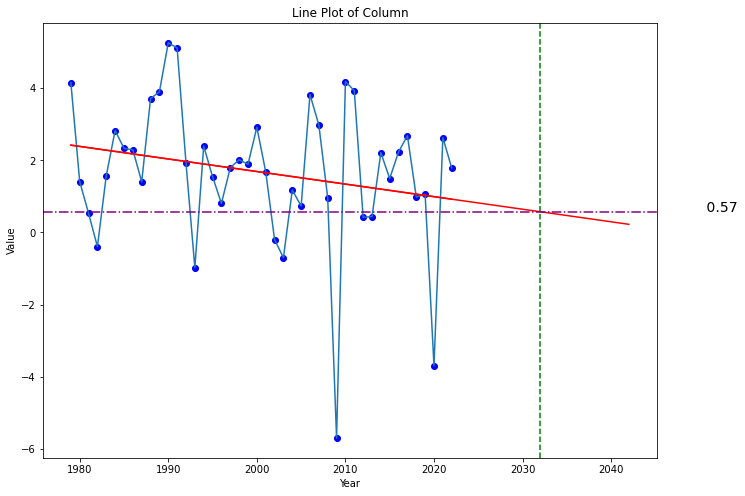

In [15]:
predict("Germany",1979,2022)

In [2]:
def growth(country,year_start,year_end):
    data = []
    years = []
    reader = csv.reader(open('API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_6224640.csv','r'), delimiter = ',', )
    for i in reader:
        if country in i:
            data = [j for j in i[4:-1]]    
        if "Country Name" in i:
            years = [j for j in i[4:-1]]

    df = pd.DataFrame({'Growth': data, 'Year': years})
    df = df.replace('', 0)
    df['Growth'] = df['Growth'].astype(float)
    df['Year'] = df['Year'].astype(int)
    
    subset = df[(df['Year'] >= year_start) & (df['Year'] <= year_end)]
    
    x = subset['Year'].values
    y = subset['Growth'].values
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    m1 = np.sum((x - x_mean)*(y - y_mean))
    m2 = np.sum((x - x_mean)**2)

    gradient = m1/m2
    intercept = y_mean-gradient*x_mean
    
    growth_at_year = df[df['Year'] == year_end]['Growth'].values[0]
    

    plt.subplots(figsize=(11,8))
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x, gradient*x + intercept, color='red', label='Linear Regression')
    plt.plot(df['Year'], df['Growth'])
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title('Line Plot of Column')
    plt.axvline(x=year_end, color='green',linestyle='--')
    plt.axhline(y=growth_at_year , color='purple', linestyle='-.')
    plt.axvspan(year_start, year_end, color=(0.95, 0.95, 0.95))
    

    end = gradient*year_end + intercept
    plt.axhline(y=gradient*year_end + intercept , color='darkorange', linestyle='-.')
    
    plt.text(year_end, growth_at_year, f"              actual: {round(growth_at_year ,2)}",fontsize=14)
    plt.text(year_end, gradient*year_end + intercept , f"                                   trend: {round(end,1)}",fontsize=14)
    

In [3]:

def arima_forcast(country, year, d):
    data = []
    years = []
    reader = csv.reader(open('API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_6224640.csv','r'), delimiter = ',', )
    for i in reader:
        if country in i:
            data = [j for j in i[4:-1]]    
        if 'Country Name' in i:
            years = [j for j in i[4:-1]]

    df = pd.DataFrame({'Growth': data, 'Year': years})
    df = df.replace('', 0)                # Handle missing values
    df['Growth'] = df['Growth'].astype(float)
    df['Year'] = df['Year'].astype(int)
    
    
# Convert 'Year' column to datetime index
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    df.set_index('Year', inplace=True)
    df = df.asfreq('AS-JAN')
    
   
    if year <2032:
        subset = df.iloc[:-(2032-year)]
    else:
        subset = df

    
# Fit the ARIMA model
    model = ARIMA(subset, order=(2, d, 2))
    model_fit = model.fit()

# Make predictions for the next 10 years
    forecast_years = pd.date_range(start=f'{year-9}-01-01', end=f'{year}-01-01', freq='AS-JAN')
    forecast = model_fit.predict(start=len(subset), end=len(subset) + 9)
    
    window_size = 10  # Specify the desired window size
    df['moving_avg'] = df['Growth'].rolling(window=window_size).mean()
    forecast1 = pd.DataFrame(forecast)
    
    ma_forecast = pd.concat([df['Growth'], forecast1['predicted_mean']]).rolling(window=window_size).mean()
    
    

# Create a plot of the actual values and the forecasted values
    plt.subplots(figsize=(11,8))
    plt.plot(df.index, df['Growth'], label='Actual')
    plt.plot(forecast_years, forecast, label='Forecast', color ="red")
    
    if year > 2022:
        plt.plot(ma_forecast, label=f'5 year Moving Average')
    else:
        plt.plot(df['moving_avg'], label=f'5 year Moving Average')
    
    plt.title('ARIMA Forecast - China GDP Growth')
    plt.xlabel('Year')
    plt.ylabel('GDP Growth')
    plt.legend()
    plt.show()
    
    print(year)
    print(f'in 2032 arima forcasts: {round(forecast[-1],2)}')
    print(f'in 2032 arima based moving average forcasts: {round(ma_forecast[-1],2)}')

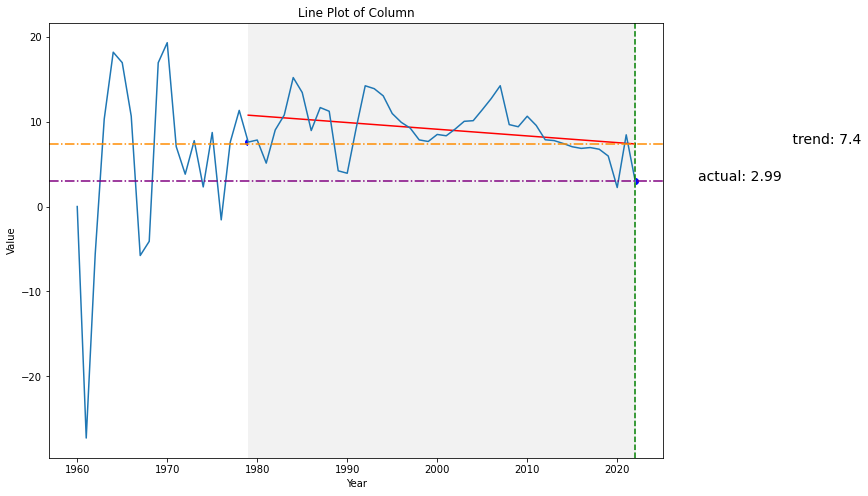

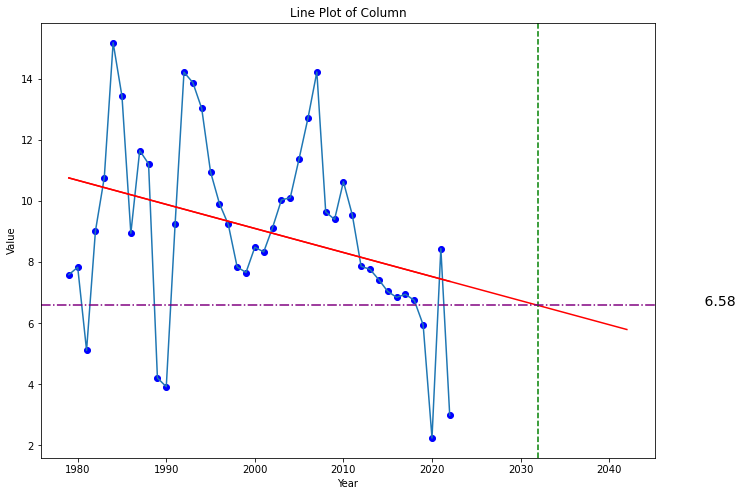

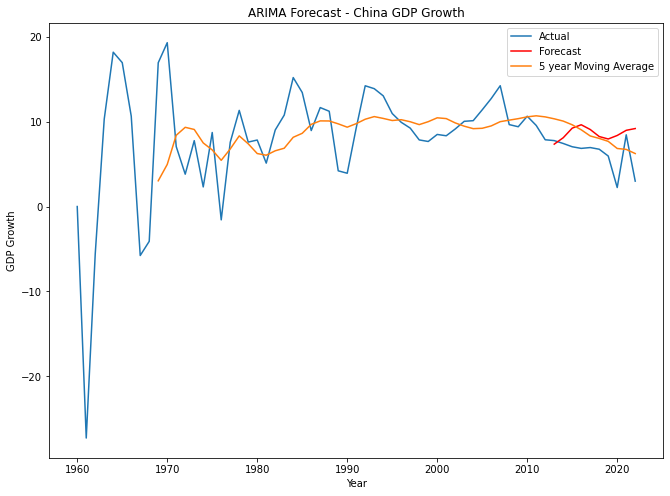

2022
in 2032 arima forcasts: 9.19
in 2032 arima based moving average forcasts: 8.61


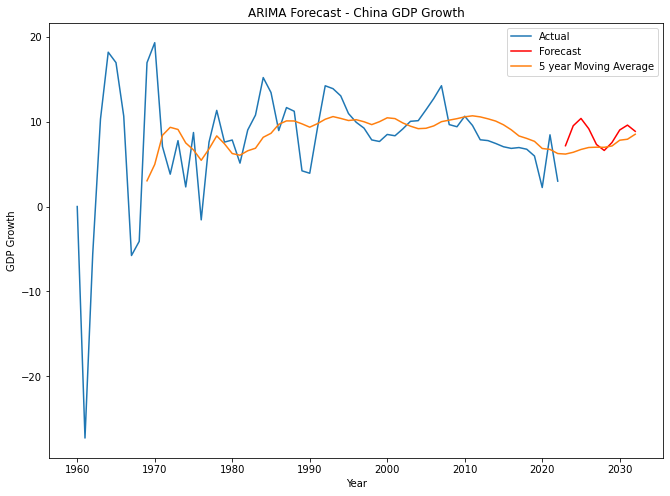

2032
in 2032 arima forcasts: 8.86
in 2032 arima based moving average forcasts: 8.51


In [4]:

growth("China",1979,2022)
predict('China',1979, 2022)
arima_forcast("China",2022, 0)
arima_forcast("China",2032, 0)